# Using seq2seq transformers for morphological inflexion: Arabic and it's "dialects"

*By Gabriel Pišvejc and Aeiria Muhammadi*

In this project, we train a number of seq2seq transformer models on different "dialects" of Arabic, using different amounts of training data. The main interest behind these experiments is that despite being called "dialects" the different varieties of Arabic are of often **not** mutually intiligible and sometimes even considered as different languages in linguistic circles.

We examine how this situation may impact training of Arabic inflexion models by testing models trained on one variety on both it's own variety and a different one and observing the impact on performance. We also perform transfer learning to see how well are the models trained on one variety able to leverage the shared linguistic basis of the varieties to enhance learning efficiency and results.

## Setup

First things first, we will download the necessary libraries and load them in.

In [ ]:
!wget https://raw.githubusercontent.com/mhulden/eztransformer/refs/heads/main/eztr.py
!mkdir downloads
!mv eztr.py downloads
## to clean up: rm downloads/eztr.py

%pip install -r "../requirements.txt"
device = "cuda"

--2026-01-03 12:21:13--  https://raw.githubusercontent.com/mhulden/eztransformer/refs/heads/main/eztr.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17140 (17K) [text/plain]
Saving to: ‘eztr.py’

eztr.py             100%[===================>]  16.74K  --.-KB/s    in 0s      

2026-01-03 12:21:13 (171 MB/s) - ‘eztr.py’ saved [17140/17140]

mkdir: cannot create directory ‘downloads’: File exists
ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../requirements.txt'


In [ ]:
import matplotlib.pyplot as plt
from typing import Literal
from datasets import load_dataset
from downloads.eztr import EZTransformer

We will also define the functions used later in the analysis. We rely on the EZTransformer library to train the models, which is an implementation of PyTorch’s `transformer()` module provided by our professor.

EZTransformer provides a streamlined training interface via its `.fit` method. For the purposes of this project, we required access to training-time metrics in order to visualize learning curves and analyze performance across epochs. At the time of writing, this functionality was not included in the library, so we contributed a [Pull Request](https://github.com/mhulden/eztransformer/pull/1) to the library to record and return the training history. This change was merged upstream, so we make use of it in this notebook.

In [ ]:
# Load the default data ########################################################

def load_data(
    lang: Literal['egyptian', 'gulf'],
    split: Literal['all', 'train', 'dev', 'no'] = 'all',
):
    lang = {'egyptian': 'arz', 'gulf': 'afb'}[lang]
    prefix = f"/content/data/{lang}/{lang}"
    files = {}
    if split in {"train", "all"}:
        files["train"] = f"{prefix}.trn"

    if split in {"train", "dev", "all", "no"}:
        files["dev"] = f"{prefix}.dev"

    if split in {"test", "all"}:
        files["test"] = f"{prefix}.tst"

    ds = load_dataset(
        'csv', delimiter="\t", data_files=files,
        column_names=["lemma", "features", "form"])

    if split == "no":
        return ds["dev"]

    return ds

# Aux function #################################################################

def process_split(split_data, batch_size: int = 100, num_proc: int = 4):
    # turn to characters
    split_data = split_data.map(
        lambda batch: {
            "lemma": [list(s) for s in batch["lemma"]],
            "form": [list(t) for t in batch["form"]],
            "features": [f.split(';') for f in batch["features"]],
        },
        batched=True,
        batch_size=batch_size,
        num_proc=num_proc,
    )

    split_data = split_data.map(
        lambda batch: {
            'src': [l+f for l, f in zip(batch["lemma"], batch["features"])]
        },
        batched=True,
        batch_size=batch_size,
        num_proc=num_proc,
        remove_columns=['features', 'lemma']
    )

    # only for compatibility with eztransformer's build_vocab
    split_data = split_data.map(
        lambda batch: {
            'src': [' '.join(item) for item in batch['src']],
            'form': [' '.join(item) for item in batch['form']],
        },
        batched=True,
        batch_size=batch_size,
        num_proc=num_proc,
    )
    return split_data

# Custom data loading ##########################################################

def load_partial(train_size: int,
                 dev_size: int,
                 test_size: int, # This test split is NOT being used downstream for now, but I am keeping it here for consistency
                 batch_size: int,
                 num_proc: int = 4,
                 lang='egyptian'):

    full_data_splits = load_data(lang=lang, split='all')

    processed_data = {}

    processed_data['train'] = full_data_splits['train'].select(range(0, train_size))

    processed_data['dev'] = full_data_splits['dev'].select(range(0, dev_size))

    processed_data['test'] = full_data_splits['test'].select(range(0, test_size))

    for split_name, split_dataset in processed_data.items():
      processed_data[split_name] = process_split(split_dataset, batch_size, num_proc)

    return processed_data

# Get a new model ##############################################################

def get_new_model():
  return EZTransformer(
    device = device,
    # learning rate
    lrt = 1e-3,
    # batch size
    bts = 256,
    # embedding
    eed = 256,
    ded = 256,
    # hidden size:
    ehs = 512,
    dhs = 512,
    # layers:
    enl = 2,
    dnl = 2,
    # heads:
    eah = 4,
    dah = 4,

    save_best = 10,

    # dropout
    drp=0.1
    )

# Model training ###############################################################

def ez_train(model, train_data, valid_data, epochs = 100, print_validation_examples = 0):
    if not isinstance(train_data, list):
        train_data = list(zip(train_data["src"], train_data["form"]))
        valid_data = list(zip(valid_data["src"], valid_data["form"]))

    # Train model
    history = model.fit(
        train_data = train_data,
        valid_data = valid_data,
        print_validation_examples = 0,
        max_epochs = epochs,
        return_history=True
        )

    model.print_validation_examples(valid_data, print_validation_examples)

    return history

# History analysis #############################################################

def training_history(history):

  min_epoch = history.loc[history["val_loss"].idxmin(), "epoch"]
  text = f"The lowest dev loss was reached in epoch {min_epoch}."

  plt.figure()
  plt.plot(history["epoch"], history["train_loss"], label="Train loss")
  plt.plot(history["epoch"], history["val_loss"], label="Dev loss")

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training and Dev loss")
  plt.legend()

  plt.show()
  print(text)


# Model testing ################################################################
def test_model(model, language):
  # Preprocess the data
  raw_test_data = load_data(lang=language, split="test")
  processed_test_data = process_split(raw_test_data["test"])

  test_inputs = processed_test_data["src"]
  test_targets = processed_test_data["form"]

  test_examples_for_printing = list(zip(processed_test_data['src'], processed_test_data['form']))

  # Use the default EZTF evaluation method
  model.score(test_inputs, test_targets)

  # Show examples
  model.print_validation_examples(test_examples_for_printing, 3)

# First experiment - Single variety trained models

## Egyptian Arabic

### Small training dataset

Having defined the functions, we can start by preparing the data for the training loop. We will pull 1000 training datapoints and another 100 datapoints to use as the dev split. In future experiments, we will also keep the dev split at 10% of the size of the train split.

In [ ]:
data = load_partial(train_size=1000,
                    dev_size = 100,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "egyptian")

Generating train split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

We will then use it to train the model.

In [ ]:
%%capture captured_output

egyptian1k = get_new_model()

history = ez_train(egyptian1k,
                   data['train'],
                   data['dev'],
                   epochs = 100)

We can then take advantage of the newly added functionality and plot the training graphs which reveal that the loss improvement sharply decreased just after the 20th epoch, after which the model just started overfitting, which didn't necesarily cause a decrease in the dev performance, however, it subjected it to a degree of variance.

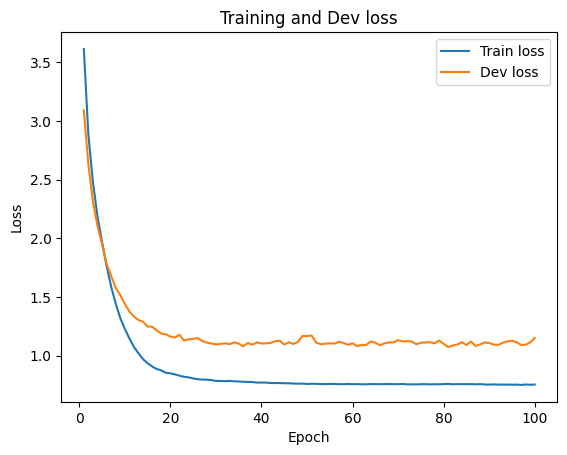

The lowest dev loss was reached in epoch 81.


In [ ]:
training_history(history)

As early stopping was not implemented, we just saved the best model based on the dev loss. We use it for evaluation on the test split, however, given the amount of training data, te performance is still quite low.

In [ ]:
test_model(egyptian1k, "egyptian")

Generating test split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Scoring: 100%|██████████| 16/16 [00:39<00:00,  2.44s/it]

Accuracy: 7.50%
Average Levenshtein Distance: 3.14

Validation Examples:
Input:     ن َ ق ّ ا ش N DEF MASC SG
Target:    ا ل ن ّ َ ق ّ ا ش
Predicted: ا ل ا ن ا ش ّ

Input:     ه َ د ّ ا ف N INDF MASC SG
Target:    ه َ د ّ ا ف
Predicted: أ َ ه ّ ا ف

Input:     م َ ق ا ل ِ ي ADJ DEF FEM SG
Target:    ا ل م َ ق ا ل ِ ي ّ َ ة
Predicted: ا ل م ق ِ ي ّ َ ة



On the Gulf set, we can see an even worse performance. What is noteworthy, however, is that the accuracy is still above zero, that is, some words, in fact do get inflected correctly.

In [ ]:
test_model(egyptian1k, "gulf")

Generating test split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Scoring: 100%|██████████| 16/16 [00:36<00:00,  2.28s/it]

Accuracy: 0.40%
Average Levenshtein Distance: 4.00

Validation Examples:
Input:     ت َ ل ا ش َ ى V PFV NOM(MASC,SG,3)
Target:    ت ل ا ش ى
Predicted: أ َ ل َ ش ا ى

Input:     ن َ ب ض N INDF MASC SG
Target:    ن ب ض
Predicted: آ َ ب

Input:     ط ُ و ل N FEM SG PSSD
Target:    ط و ل ة
Predicted: آ ل َ ة



### Medium training dataset

For the medium dataset, we will do everything in a very similar fashion, except for the amount of data, which will naturally be bigger.

In [ ]:
%%capture captured_output

data = load_partial(train_size=5000,
                    dev_size = 500,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "egyptian")

egyptian5k = get_new_model()

history = ez_train(egyptian5k,
                   data['train'],
                   data['dev'],
                   epochs = 100)

In terms of loss evolution across epochs, we can notice that the same pattern repeats, except for the fact that the model starts overfitting even faster.

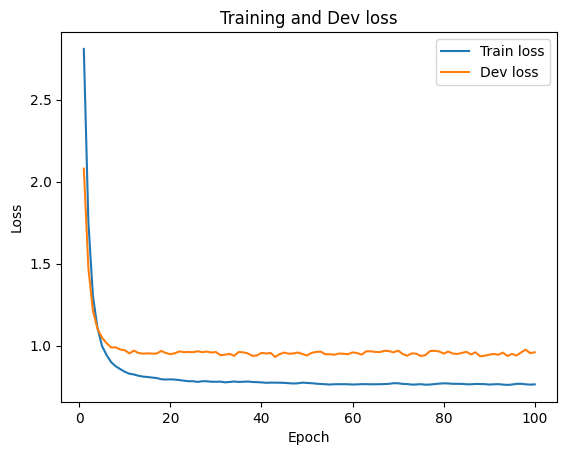

The lowest dev loss was reached in epoch 43.


In [ ]:
training_history(history)

Despite that, we can notice that the accuracy improves shaply on Egyptian Arabic:

In [ ]:
test_model(egyptian5k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:41<00:00,  2.57s/it]


Accuracy: 47.60%
Average Levenshtein Distance: 1.22

Validation Examples:
Input:     غ ُ ر ْ ز َ ة N FEM SG PSSD
Target:    غ ُ ر ْ ز َ ة
Predicted: ا ُ غ ْ ر َ ة

Input:     ا ِ ت ْ ن َ س َ ى V PFV NOM(MASC,SG,3)
Target:    ا ِ ت ْ ن َ س َ ى
Predicted: ا ِ ت ْ ن َ س َ ى

Input:     م َ ك ْ ت ُ و ب ADJ FEM SG PSSD
Target:    م َ ك ْ ت ُ و ب َ ة
Predicted: م َ ك ْ ت ُ و ب َ ة



We can however notice that the performance on Gulf Arabic drops to around where the previous model was on it's own variety.

In [ ]:
test_model(egyptian5k, "gulf")

Scoring: 100%|██████████| 16/16 [00:37<00:00,  2.35s/it]

Accuracy: 8.10%
Average Levenshtein Distance: 2.98

Validation Examples:
Input:     ط ا ب V PFV NOM(PL,1)
Target:    ط ِ ب ن ا
Predicted: ن ُ ب ُ و ا

Input:     ر َ أ س N MASC SG PSSD
Target:    ر أ س
Predicted: ر َ أ

Input:     ش ا ع ِ ر N MASC SG PSSD
Target:    ش ا ع ر
Predicted: ش ا ع ِ ر



### Large training dataset

We will once again repeat the pattern of training a new model, but with more data. However, this time, we will also change the number of epochs. As the training is getting progressively longer and additional epochs have to shown to only introduce variance and overfitting, we will only train for 20 of them.

In [ ]:
%%capture captured_output

data = load_partial(train_size=10000,
                    dev_size = 1000,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "egyptian")

egyptian10k = get_new_model()

history = ez_train(egyptian10k,
                   data['train'],
                   data['dev'],
                   epochs = 20)

In terms of loss evolution, as predicted, the overfitting sets in even quicker then before.

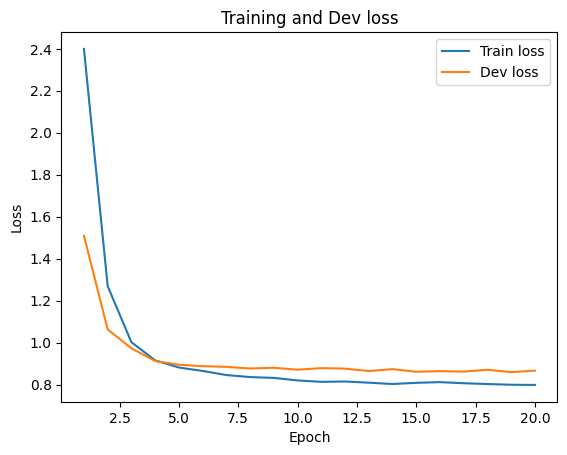

The lowest dev loss was reached in epoch 19.


In [ ]:
training_history(history)

In terms of evaluation metrics, we once againg observe a strong improvement on the model's own variety.

In [ ]:
test_model(egyptian10k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:41<00:00,  2.58s/it]

Accuracy: 85.30%
Average Levenshtein Distance: 0.31

Validation Examples:
Input:     م ِ ت ق َ س ّ ِ م ADJ MASC PL PSSD
Target:    م ِ ت ق َ س ّ ِ م ِ ي ن
Predicted: م ِ ت ق َ س ّ ِ م ِ ي ن

Input:     ج َ م ْ ب N MASC DU PSSD
Target:    ج َ م ْ ب َ ي ن
Predicted: ج َ م ْ ب َ ب

Input:     ك َ س ّ َ ر V PFV NOM(MASC,SG,3)
Target:    ك َ س ّ َ ر
Predicted: ك َ س ّ َ ر



However, the model still finds it very hard to do inflexion on a different variety of Arabic.

In [ ]:
test_model(egyptian10k, "gulf")

Scoring: 100%|██████████| 16/16 [00:37<00:00,  2.35s/it]

Accuracy: 11.50%
Average Levenshtein Distance: 2.49

Validation Examples:
Input:     ع َ م َ ل V IPFV NOM(FEM,SG,3)
Target:    ت ِ ع م ِ ل
Predicted: ت ِ ع ْ م ِ ل

Input:     ب ِ غ ِ ي V IPFV NOM(FEM,SG,2)
Target:    ت ب ي
Predicted: ت ِ ب ْ غ ِ ي

Input:     م ِ ق ا ب ِ ل N MASC SG PSSD
Target:    م ق ا ب ل
Predicted: م ِ ق ا ب ِ ل



## Gulf Arabic

We will now examine the same process on a different variety. We will train on the Gulf variety and analyse performance on the model's "native" variety and then once again on Egyptian Arabic.

### Small training dataset

In [ ]:
%%capture captured_output

data = load_partial(train_size=1000,
                    dev_size = 100,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "gulf")

gulf1k = get_new_model()

history = ez_train(gulf1k,
                   data['train'],
                   data['dev'],
                   epochs = 50)

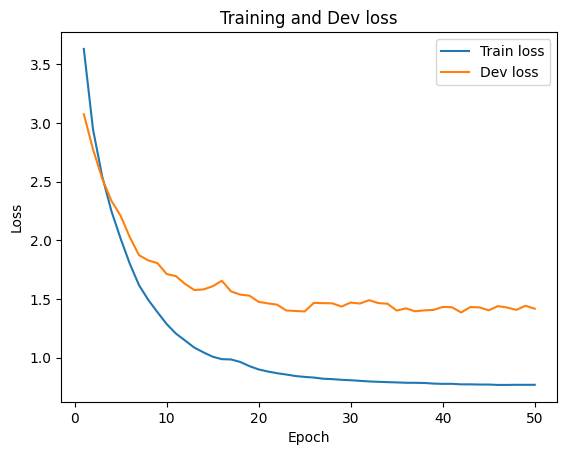

The lowest dev loss was reached in epoch 42.


In [ ]:
training_history(history)

We can see that the 1000 datapoints model shows notably worse results both on its own variety and on the other one, where it even reaches 0% accuracy, that is, no correctly inflected words whatsoever.

In [ ]:
test_model(gulf1k, "gulf")

Scoring: 100%|██████████| 16/16 [00:27<00:00,  1.73s/it]

Accuracy: 4.00%
Average Levenshtein Distance: 3.08

Validation Examples:
Input:     ت أ َ خ ّ َ ر V IPFV NOM(MASC,SG,2)
Target:    ت ِ ت أ َ خ ّ َ ر
Predicted: ت خ ر

Input:     ح َ د ّ َ د V IMP NOM(FEM,SG,2)
Target:    ح َ د ّ د ِ ي
Predicted: ح د ي

Input:     س َ ر َ ط - ُ ِ V IPFV NOM(MASC,SG,3)
Target:    ي س ر ط
Predicted: ي س ط ن



In [ ]:
test_model(gulf1k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]

Accuracy: 0.00%
Average Levenshtein Distance: 5.04

Validation Examples:
Input:     م َ ل َ أ V PFV NOM(MASC,SG,3)
Target:    م َ ل َ أ
Predicted: ت م ل

Input:     ت َ ح ْ س ِ ي ن N INDF MASC SG
Target:    ت َ ح ْ س ِ ي ن
Predicted: ا ت ح س

Input:     ا ِ س ْ ت َ ع ْ م ِ ل V IPFV NOM(SG,1)
Target:    ا َ س ْ ت َ ع ْ م ِ ل
Predicted: ا س ت َ م ل ع



### Medium training dataset

In [ ]:
%%capture captured_output

data = load_partial(train_size=5000,
                    dev_size = 500,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "gulf")

gulf5k = get_new_model()

history = ez_train(gulf5k,
                   data['train'],
                   data['dev'],
                   epochs = 50)

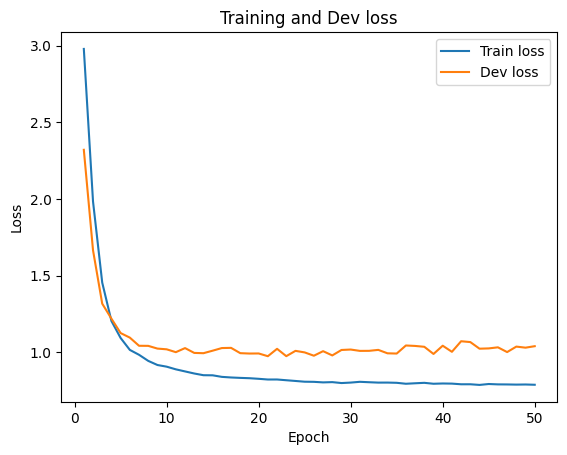

The lowest dev loss was reached in epoch 21.


In [ ]:
training_history(history)

Once again, we observe a sharp improvement in the evaluation metrics in the variety upon which the model trained upon and a small improvement in the second variety.

In [ ]:
test_model(gulf5k, "gulf")

Scoring: 100%|██████████| 16/16 [00:30<00:00,  1.90s/it]

Accuracy: 48.60%
Average Levenshtein Distance: 1.12

Validation Examples:
Input:     م ِ ح َ و ّ ِ ل ADJ INDF MASC SG
Target:    م ح و ل
Predicted: ت ح م و ل

Input:     ص َ غ ّ َ ر V IPFV NOM(FEM,SG,3)
Target:    ت ص َ غ ّ ِ ر
Predicted: ت غ َ ص ّ ِ ر

Input:     ك ِ ر ِ ي م ا N INDF FEM SG
Target:    ك ر ي م ا
Predicted: ر ك ي م ا م ة



In [ ]:
test_model(gulf5k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:29<00:00,  1.85s/it]

Accuracy: 3.20%
Average Levenshtein Distance: 3.54

Validation Examples:
Input:     ر َ ض َ ع V IPFV NOM(FEM,SG,3)
Target:    ت ِ ر ْ ض َ ع
Predicted: ت ِ ر ض ِ ع

Input:     ح َ ر َ ق V IPFV NOM(MASC,SG,2)
Target:    ت ِ ح ْ ر َ ق
Predicted: ت ِ ح ر ق ِ ق

Input:     ت َ ع ْ ر ِ ي ض N MASC SG PSSD
Target:    ت َ ع ْ ر ِ ي ض
Predicted: ت ع ر ي ا



### Large training dataset


In [ ]:
%%capture captured_output

data = load_partial(train_size=10000,
                    dev_size = 1000,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "gulf")

gulf10k = get_new_model()

history = ez_train(gulf10k,
                   data['train'],
                   data['dev'],
                   epochs = 20)

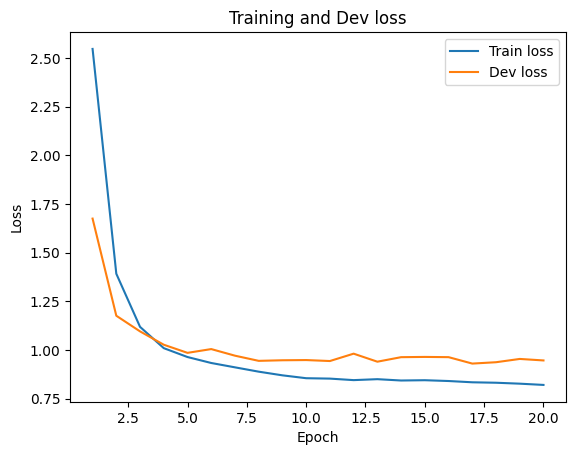

The lowest dev loss was reached in epoch 17.


In [ ]:
training_history(history)

And finally, we can once again see that the model is capable to generalize to a decent degree on its own variety, but struggles greatly with the other "dialect".

In [ ]:
test_model(gulf10k, "gulf")

Scoring: 100%|██████████| 16/16 [00:31<00:00,  1.98s/it]

Accuracy: 73.40%
Average Levenshtein Distance: 0.58

Validation Examples:
Input:     ح ا ب ِ ِ س ADJ MASC SG PSSD
Target:    ح ا ب س
Predicted: ح ا ب س

Input:     ع ا ج ِ ز ADJ INDF FEM SG
Target:    ع ا ج ز ة
Predicted: ع ا ج ز ة

Input:     ا َ ه ب َ ل ADJ INDF FEM SG
Target:    ه ب ل ة
Predicted: ا ه ب ل ى



In [ ]:
test_model(gulf10k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:29<00:00,  1.87s/it]

Accuracy: 4.50%
Average Levenshtein Distance: 3.04

Validation Examples:
Input:     ل ِ ب ا س N DEF MASC SG
Target:    ا ل ل ّ ِ ب ا س
Predicted: ا ل ل ب ا س

Input:     ع ِ ن ْ و ا ن N DEF MASC PL
Target:    ا ل ع َ ن ا و ِ ي ن
Predicted: ا ل ع ن و ن ا ت

Input:     ا ِ ر ا د َ ة N INDF FEM SG
Target:    ا ِ ر ا د َ ة
Predicted: ا ر ا د ة



# Conclusions - Single variety trained models

In this experiment, we have shown the problems transformers have in terms of generalization between different Arabic "dialects". This can be largely explained by theoretical linguistics. While this is by no means an exhaustive explanation, we can take a look at the different morphological patterns in both varieties. For example, the verbal conjugations of the verb يعمل (to work) in present plural.

| Morphology | Egyptian                 | Gulf                    |
| ---------- | ------------------------ | ----------------------- |
| 1.p. pl.   | نِعْمِل - /niʕmil/       | نِعمِل - /niʕmil/       |
| 2.p. pl.   | تِعْمِلُوا - /tiʕmiluwa/ | تِعمُلُون - /tiʕmuluwn/ |
| 3.p. pl.   | يِعْمِلُوا - /jiʕmiluwa/ | يِعمُلُون - /jiʕmuluwn/ |

We can see that the morphemes used to form the second and third person are not shared across varieties. Similar phenomena take place in essentially all morphological paradigms. Another factor complicating the task at hand is that not all morphological categories are shared between the varieties. An example of this would be the absence of the dual number in Egyptian verbs.



In [ ]:
%%capture captured_output

data = load_partial(train_size=1000,
                    dev_size = 100,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "gulf")

egyptian10kgulf1k = egyptian10k

history = ez_train(egyptian10kgulf1k,
                   data['train'],
                   data['dev'],
                   epochs = 50)

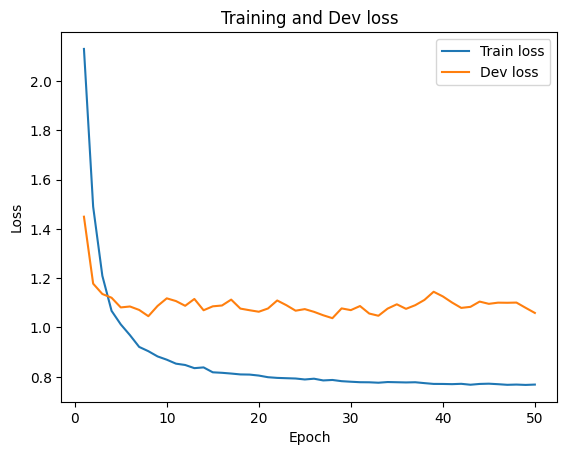

The lowest dev loss was reached in epoch 28.


In [ ]:
training_history(history)

In [ ]:
test_model(egyptian10kgulf1k, "gulf")

Scoring: 100%|██████████| 16/16 [00:28<00:00,  1.78s/it]

Accuracy: 17.70%
Average Levenshtein Distance: 2.13

Validation Examples:
Input:     ص ُ ع ل ُ و ك N DEF MASC SG
Target:    ا ل ص ع ل و ك
Predicted: ا ل ا ص ل و ك

Input:     ط ا ب V IMP NOM(FEM,SG,2)
Target:    ط ِ ي ِ ب ِ ي
Predicted: ط ا ب ي

Input:     ا ِ ف ت َ ر ّ V IMP NOM(FEM,SG,2)
Target:    ا ِ ف ت َ ر ّ ِ ي
Predicted: ا ِ ف ت َ ر ّ ِ ي



In [ ]:
test_model(egyptian10kgulf1k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]

Accuracy: 0.60%
Average Levenshtein Distance: 3.96

Validation Examples:
Input:     ز َ ب ّ ا ل N INDF MASC SG
Target:    ز َ ب ّ ا ل
Predicted: ز ل ا ب

Input:     م َ ق ْ ل ِ ي ADJ MASC SG PSSD
Target:    م َ ق ْ ل ِ ي
Predicted: م ل ق

Input:     ق ا ف ِ ل ADJ INDF FEM SG
Target:    ق ا ف ْ ل َ ة
Predicted: ق ا ف ل ى



In [ ]:
%%capture captured_output

data = load_partial(train_size=5000,
                    dev_size = 500,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "gulf")

egyptian10kgulf5k = egyptian10k

history = ez_train(egyptian10kgulf5k,
                   data['train'],
                   data['dev'],
                   epochs = 50)

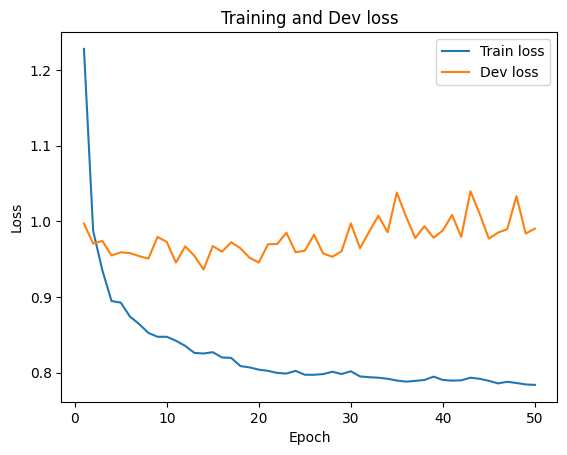

The lowest dev loss was reached in epoch 14.


In [ ]:
training_history(history)

In [ ]:
test_model(egyptian10kgulf5k, "gulf")

Scoring: 100%|██████████| 16/16 [00:31<00:00,  1.98s/it]

Accuracy: 59.20%
Average Levenshtein Distance: 0.81

Validation Examples:
Input:     ق َ ص ر N INDF MASC SG
Target:    ق ص ر
Predicted: ق ر ص

Input:     ا ِ ت ّ َ ج َ ه V IPFV NOM(MASC,SG,3)
Target:    ي ِ ت ّ ِ ج ِ ه
Predicted: ي ِ ت ّ ِ ج

Input:     ا ِ م ت َ ح َ ن V IPFV NOM(MASC,SG,3)
Target:    ي ِ م ت ِ ح ِ ن
Predicted: ي ِ م ت ِ ح ِ ن



In [ ]:
test_model(egyptian10kgulf5k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:30<00:00,  1.91s/it]


Accuracy: 3.50%
Average Levenshtein Distance: 3.20

Validation Examples:
Input:     ب ا ط ِ ل ADJ FEM SG PSSD
Target:    ب ا ط ِ ل َ ة
Predicted: ب ا ط ل ة

Input:     ن َ ف ْ س N INDF MASC SG
Target:    ن َ ف ْ س
Predicted: ن ف س

Input:     إ ِ ل ِ ي ك ْ ت ِ ر ُ و ن ِ ي ّ ADJ DEF FEM SG
Target:    ا ل إ ِ ل ِ ي ك ْ ت ِ ر ُ و ن ِ ي ّ َ ة
Predicted: ا ل ا ل ي ك ر ت



In [ ]:
%%capture captured_output

data = load_partial(train_size=10000,
                    dev_size = 1000,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "gulf")

egyptian10kgulf10k = egyptian10k

history = ez_train(egyptian10kgulf10k,
                   data['train'],
                   data['dev'],
                   epochs = 20)

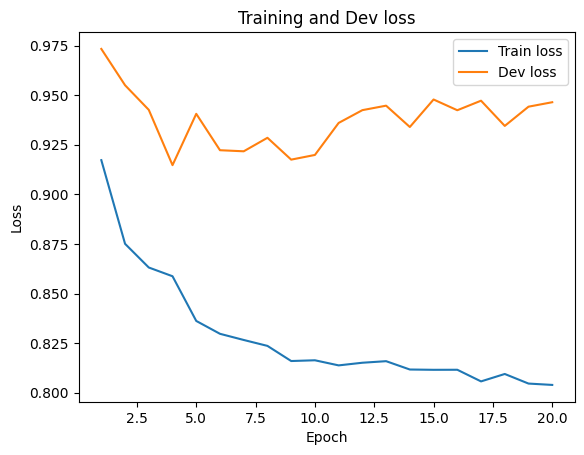

The lowest dev loss was reached in epoch 4.


In [ ]:
training_history(history)

In [ ]:
test_model(egyptian10kgulf10k, "gulf")

Scoring: 100%|██████████| 16/16 [00:31<00:00,  1.96s/it]

Accuracy: 72.30%
Average Levenshtein Distance: 0.56

Validation Examples:
Input:     ا ِ ت غ َ د ّ َ ى V PFV NOM(MASC,SG,3)
Target:    ت غ د ى
Predicted: ا ت غ د ى

Input:     ش َ ل ّ V IMP NOM(FEM,SG,2)
Target:    ش ِ ل ّ ِ ي
Predicted: ش ِ ل ّ ِ ي

Input:     ك َ ش ّ َ ر V PFV NOM(FEM,SG,2)
Target:    ك َ ش ّ َ ر ت ِ ي
Predicted: ك َ ش ّ َ ر ت ِ ي



In [ ]:
test_model(egyptian10kgulf10k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it]

Accuracy: 4.50%
Average Levenshtein Distance: 2.92

Validation Examples:
Input:     ب َ ص ّ V IPFV NOM(PL,1)
Target:    ن ِ ب ُ ص ّ
Predicted: ن ب ِ ص ّ

Input:     م ُ ح ا ف ْ ظ َ ة N FEM PL PSSD
Target:    م ُ ح ا ف ْ ظ ا ت
Predicted: م ح ا ف ظ ا ت

Input:     ب ِ ع ِ ي د N INDF MASC SG
Target:    ب ُ ع ا د
Predicted: ب ع ي د



In [ ]:
%%capture captured_output

data = load_partial(train_size=1000,
                    dev_size = 100,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "egyptian")

gulf10kegyptian1k = gulf10k

history = ez_train(gulf10kegyptian1k,
                   data['train'],
                   data['dev'],
                   epochs = 50)

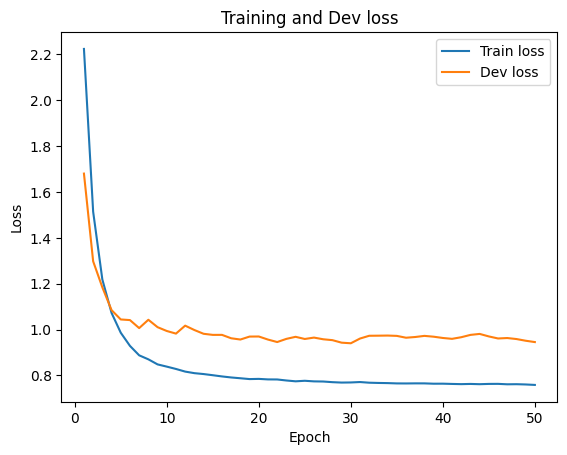

The lowest dev loss was reached in epoch 30.


In [ ]:
training_history(history)

In [ ]:
test_model(gulf10kegyptian1k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:40<00:00,  2.52s/it]


Accuracy: 32.00%
Average Levenshtein Distance: 1.53

Validation Examples:
Input:     غ ا ز N INDF MASC SG
Target:    غ ا ز
Predicted: غ ا ز

Input:     ط َ ي ّ ا ر َ ة N FEM PL PSSD
Target:    ط َ ي ّ ا ر ا ت
Predicted: ط َ ي ّ ا ر ا ت

Input:     ت َ ح َ س ّ ُ ن N DEF MASC SG
Target:    ا ل ت ّ َ ح َ س ّ ُ ن
Predicted: ا ل ت ح َ س ّ َ ن



In [ ]:
test_model(gulf10kegyptian1k, "gulf")

Scoring: 100%|██████████| 16/16 [00:38<00:00,  2.40s/it]

Accuracy: 16.80%
Average Levenshtein Distance: 2.06

Validation Examples:
Input:     ك ِ ي ر م N DEF MASC SG
Target:    ا ل ك ي ر م
Predicted: ا ل ك ُ ر

Input:     ا ِ ف ت َ ر ّ V IMP NOM(MASC,SG,2)
Target:    ا ِ ف ت َ ر ّ
Predicted: ا ِ ف ت َ ر ّ

Input:     ه َ ي م ا ن ADJ MASC SG PSSD
Target:    ه ي م ا ن
Predicted: ه َ ي م ا ن



In [ ]:
%%capture captured_output

data = load_partial(train_size=5000,
                    dev_size = 500,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "egyptian")

gulf10kegyptian5k = gulf10k

history = ez_train(gulf10kegyptian5k,
                   data['train'],
                   data['dev'],
                   epochs = 50)

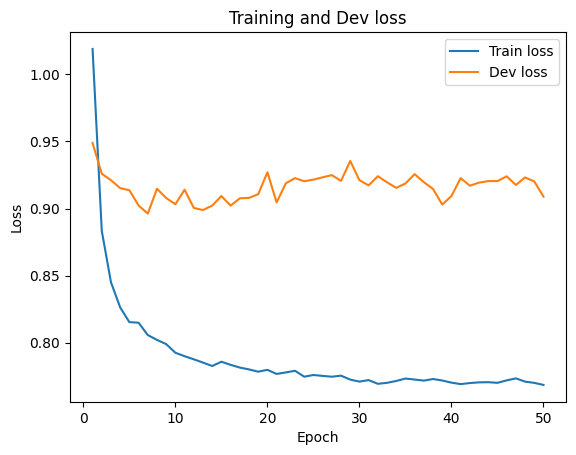

The lowest dev loss was reached in epoch 7.


In [ ]:
training_history(history)

In [ ]:
test_model(gulf10kegyptian5k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:42<00:00,  2.65s/it]


Accuracy: 79.20%
Average Levenshtein Distance: 0.40

Validation Examples:
Input:     ت َ ع ْ ر ِ ي ض N DEF MASC SG
Target:    ا ل ت ّ َ ع ْ ر ِ ي ض
Predicted: ا ل ت ّ َ ع ْ ر ِ ي ض

Input:     ت ِ ر ْ س ا ن َ ة N INDF FEM SG
Target:    ت ِ ر ْ س ا ن َ ة
Predicted: ت ِ ر ْ س ا ن َ ة

Input:     م َ ف ْ ت ُ و ح ADJ DEF MASC SG
Target:    ا ل م َ ف ْ ت ُ و ح
Predicted: ا ل م ّ َ ف ْ ت ُ و ح



In [ ]:
test_model(gulf10kegyptian5k, "gulf")

Scoring: 100%|██████████| 16/16 [00:39<00:00,  2.45s/it]

Accuracy: 12.60%
Average Levenshtein Distance: 2.34

Validation Examples:
Input:     ا ِ ن ش َ ق ّ V IPFV NOM(MASC,SG,2)
Target:    ت ِ ن ش َ ق ّ
Predicted: ت ِ ن ش َ ق ّ

Input:     ش ا ع ِ ر N DEF MASC SG
Target:    ا ل ش ا ع ر
Predicted: ا ل ش ّ ا ع ِ ر

Input:     ا َ ج ّ َ ر V IPFV NOM(PL,1)
Target:    ا ج ر
Predicted: ن ِ ا ج ّ َ ر



In [ ]:
%%capture captured_output

data = load_partial(train_size=10000,
                    dev_size = 1000,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "egyptian")

gulf10kegyptian10k = gulf10k

history = ez_train(gulf10kegyptian10k,
                   data['train'],
                   data['dev'],
                   epochs = 20)

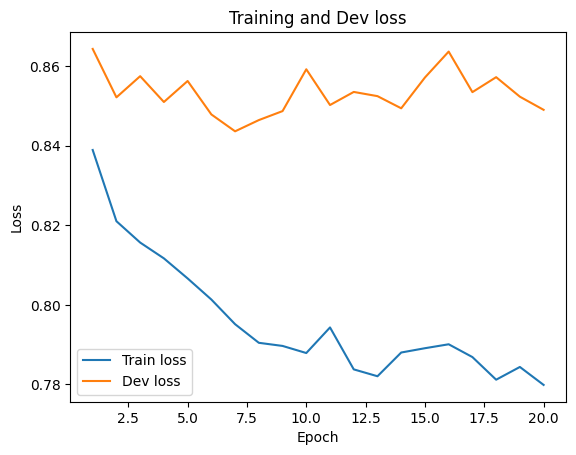

The lowest dev loss was reached in epoch 7.


In [ ]:
training_history(history)

In [ ]:
test_model(gulf10kegyptian10k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:41<00:00,  2.61s/it]

Accuracy: 86.30%
Average Levenshtein Distance: 0.27

Validation Examples:
Input:     ا ِ ت ْ ج َ س ّ ِ س V PFV NOM(MASC,SG,3)
Target:    ا ِ ت ْ ج َ س ّ ِ س
Predicted: ا ِ ت ْ ج َ س ّ ِ س

Input:     ع َ ز َ م V IPFV NOM(PL,1)
Target:    ن ِ ع ْ ز ِ م
Predicted: ن ِ ع ْ ز ِ م

Input:     ت َ ح ْ ر ِ ي ك N INDF MASC SG
Target:    ت َ ح ْ ر ِ ي ك
Predicted: ت َ ح ْ ر ِ ي ك



In [ ]:
test_model(gulf10kegyptian10k, "gulf")

Scoring: 100%|██████████| 16/16 [00:39<00:00,  2.50s/it]

Accuracy: 12.90%
Average Levenshtein Distance: 2.31

Validation Examples:
Input:     ا َ ن ّ َ ب V PFV NOM(MASC,SG,3)
Target:    ا ن ب
Predicted: أ َ ن ّ َ ب

Input:     ا َ م ا ن N MASC SG PSSD
Target:    ا م ا ن
Predicted: أ َ م ا ن

Input:     ع َ ش ّ َ ى V PFV NOM(FEM,SG,3)
Target:    ع َ ش ّ َ ت
Predicted: ع َ ش ّ ِ ت

